In [32]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### MobileNet V2 Trained by Google

In [33]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = 224

In [34]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# train_dir = 'C:/Users/Nick/Desktop/stock images/train'
# validation_dir = 'C:/Users/Nick/Desktop/stock images/validation'

In [37]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))
class_names = train_dataset.class_names

Found 4404 files belonging to 3 classes.
Found 3984 files belonging to 3 classes.


In [38]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 100
Number of test batches: 25


In [39]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [40]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [41]:
# Unfreeze this to train
base_model.trainable = False

# Adding a classification head using max
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_max_layer(feature_batch)
# print(feature_batch_average.shape)

# Add a dense layer to convert it to a single prediction per image , activation='softmax'
prediction_layer = tf.keras.layers.Dense(len(class_names)) 
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

# Process the inputs so that they are between [-1, 1] and then
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Add the preprocessing layer
x = preprocess_input(inputs)
# Add the base model after, keeping training to false
x = base_model(x, training=False)
# Add max pooling layer
x = global_max_layer(x)
# Add dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Add softmax prediction layer
outputs = prediction_layer(x)
# Create a model from inputs, outputs.
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [42]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # False when we have a softmax layer
              metrics=['accuracy'])

In [43]:
loss0, accuracy0 = model.evaluate(validation_dataset)

100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 319ms/step - accuracy: 0.2802 - loss: 4.1306


In [44]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=5,
                    validation_data=validation_dataset,
                    validation_steps=5)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 797ms/step - accuracy: 0.3331 - loss: 3.5108 - val_accuracy: 0.3187 - val_loss: 2.1227
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 798ms/step - accuracy: 0.3774 - loss: 2.5040 - val_accuracy: 0.3500 - val_loss: 1.8592
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step - accuracy: 0.3846 - loss: 2.2824 - val_accuracy: 0.2812 - val_loss: 1.9270
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - accuracy: 0.3298 - loss: 2.4800 - val_accuracy: 0.4875 - val_loss: 2.1524
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step - accuracy: 0.4622 - loss: 2.6987 - val_accuracy: 0.4000 - val_loss: 1.4779
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - accuracy: 0.2507 - loss: 2.6837 - val_accuracy: 0.2875 - val_loss: 1.8467
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - accuracy: 0.3231 - loss: 2.0641 - val_accuracy: 0.4625 - val_loss: 1.9783
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - accuracy: 0.4002 - loss: 2.6646 - val_accuracy: 0.3187 - val_loss:

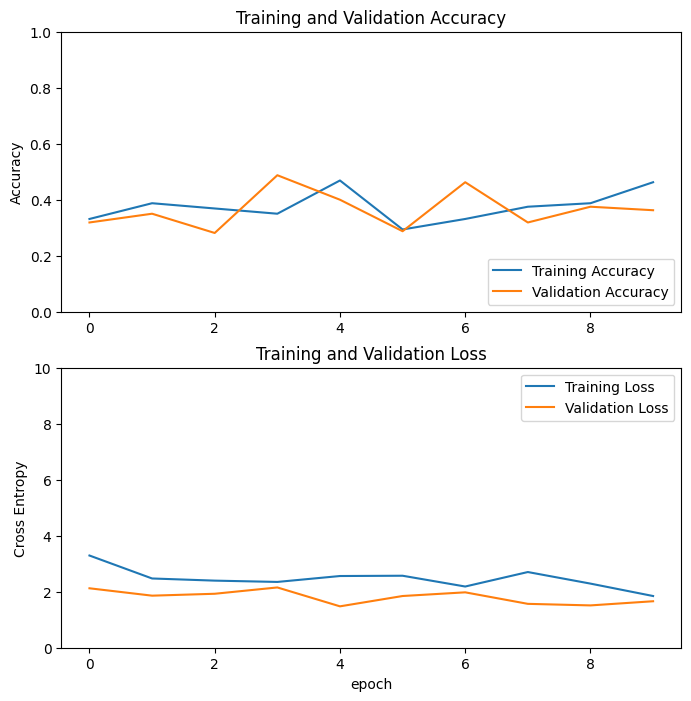

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylim([0, 10])
plt.show()

In [46]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 115

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [49]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,515 (8.66 MB)

 Trainable params: 1,685,187 (6.43 MB)

 Non-trainable params: 576,640 (2.20 MB)

 Optimizer params: 7,688 (30.04 KB)

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # False when we have a Softmax layer
              metrics=['accuracy'])

In [51]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         steps_per_epoch=5,
                         validation_data=validation_dataset,
                         validation_steps=5)

Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3067 - loss: 4.1384 - val_accuracy: 0.3063 - val_loss: 1.9126
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - accuracy: 0.4313 - loss: 3.1285 - val_accuracy: 0.2750 - val_loss: 2.9514
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.3589 - loss: 3.8766 - val_accuracy: 0.2188 - val_loss: 3.5294
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.3005 - loss: 3.7545 - val_accuracy: 0.2375 - val_loss: 2.3137
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step - accuracy: 0.4374 - loss: 3.0164 - val_accuracy: 0.3750 - val_loss: 1.8255
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 871ms/step - accuracy: 0.3483 - loss: 3.4288 - val_accuracy: 0.3688 - val_loss: 1.6864
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 853ms/step - accuracy: 0.3638 - loss: 3.0153 - val_accuracy: 0.5125 - val_loss: 1.4793
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 857ms/step - accuracy: 0.3399 - loss: 3.2883 - val_accuracy: 0.4062 - val

In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

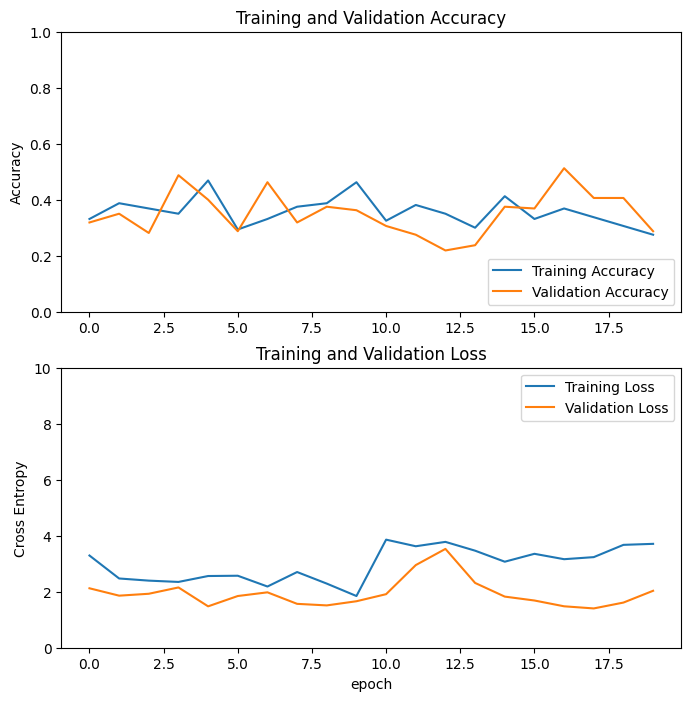

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylim([0, 10])
plt.show()

In [54]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - accuracy: 0.2721 - loss: 2.0085
Test accuracy : 0.26750001311302185


In [55]:
# Add a softmax layer to our model and apply our test data
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = probability_model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


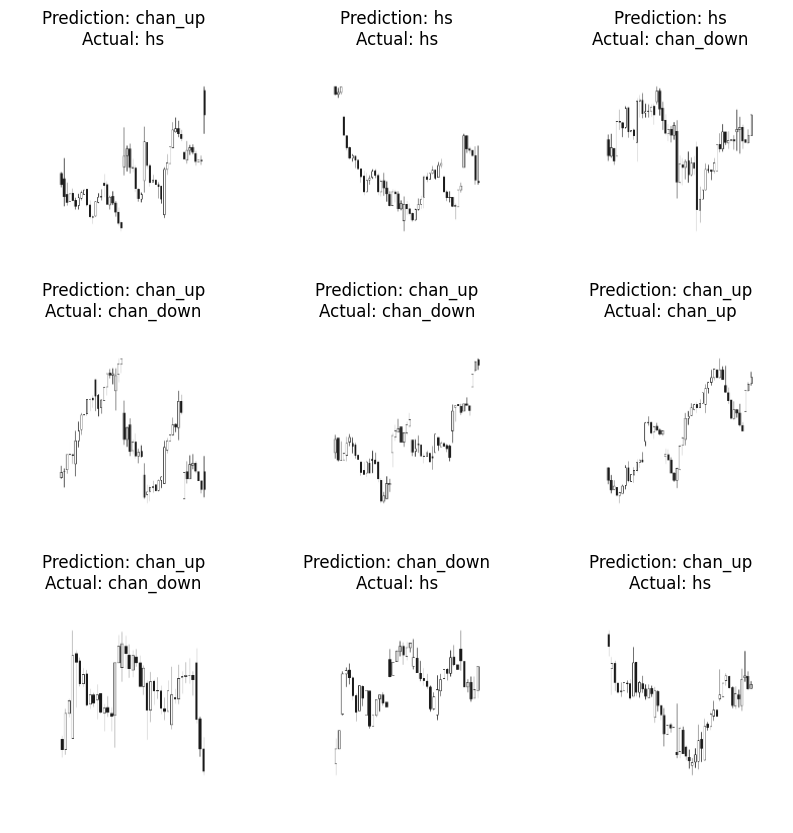

In [56]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  guess = str(class_names[np.argmax(predictions[i+9])])
  actual = str(class_names[label_batch[i+9]])
  title = "Prediction: " + guess + "\n" + "Actual: " + actual
  plt.title(title)
  plt.axis("off")